# Getting Started with `nflows` & `flowtorch` 
https://github.com/bayesiains/nflows

https://flowtorch.ai/users

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils import data
import torch.nn as nn
from torch import optim
import torch.distributions as D

import flowtorch.bijectors as bij
import flowtorch.distributions as dist
import flowtorch.parameters as params

from toy_data import inf_train_gen


from eval import plot_pdfs_1D, plot_2d_pdf_contours

## Target distributions for synthetic data

We do not usually know them... but we have access to samples!

We will try to approximate them using the samples!

In [ ]:
# Data Dimensions
n = 500 # Number of datapoints
d = 2 # Dimension of the multivariate distribution

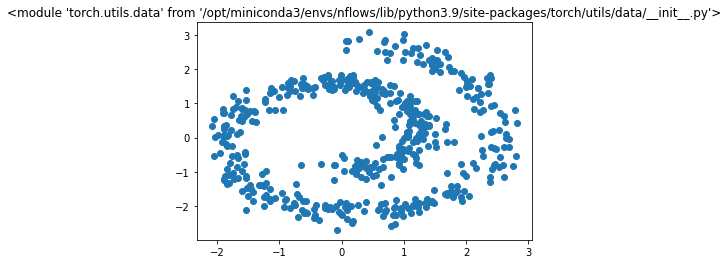

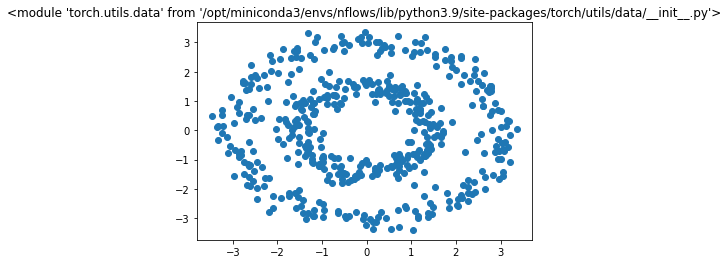

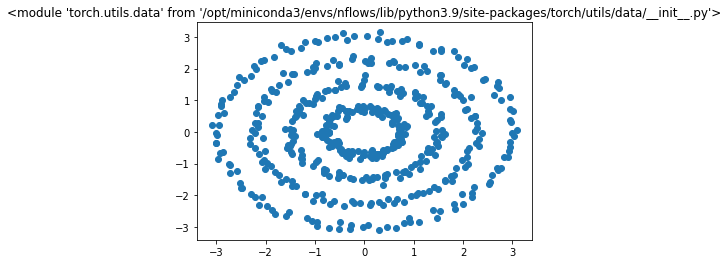

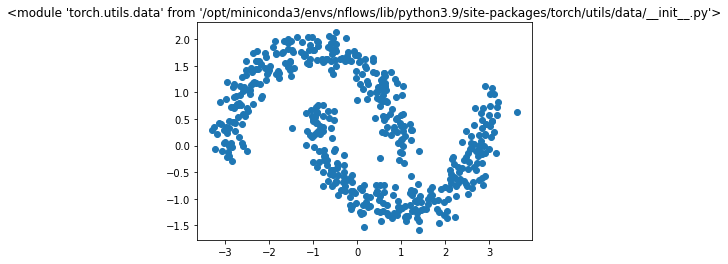

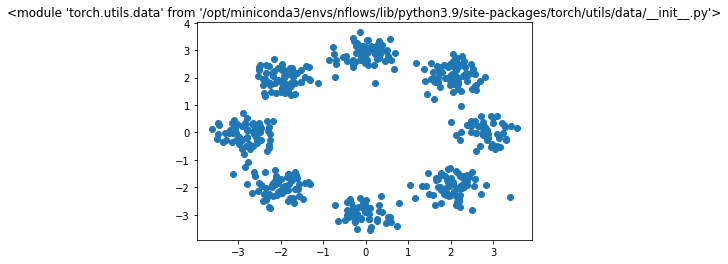

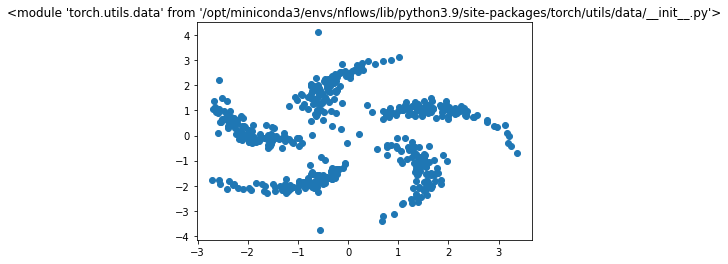

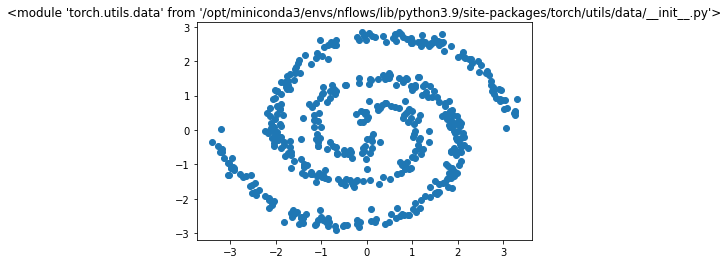

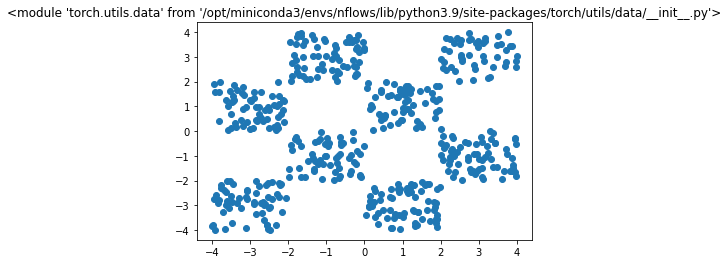

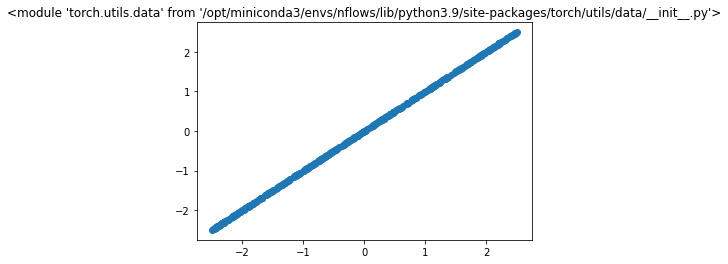

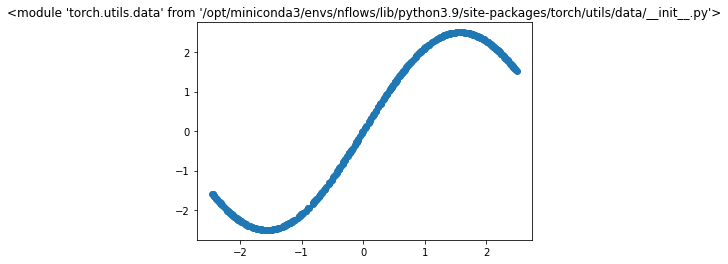

In [ ]:
# Toy Data from Gilles Louppe's blog-post `toy_data`
toy_data = ['swissroll', 'circles', 'rings', 'moons', '8gaussians', 'pinwheel', '2spirals', 'checkerboard', 'line', 'cos']

# Plot training samples for each toy data 
for td in toy_data:
    x = inf_train_gen(data=td, batch_size=n)
    plt.scatter(x=x[:,0], y=x[:,1]) 
    plt.title(data)
    plt.show()

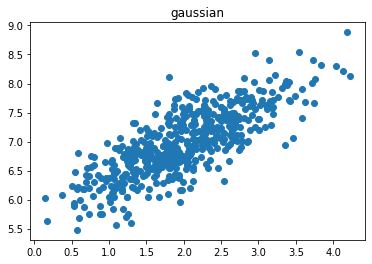

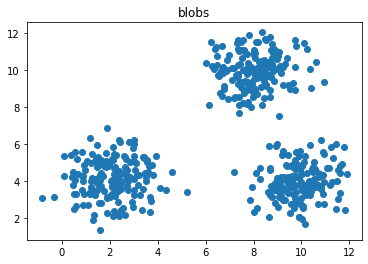

In [ ]:
# Gaussian 2D target distributions: Multivartiate Gaussian and GMM Blobs 

# Multivariate Gaussian distribution
means = torch.FloatTensor([2, 7])
# cov_matrix = torch.eye(d)*0.2 + torch.rand((d,d))
cov_matrix = torch.FloatTensor([[0.5, 0.5],[0.3, 0.3]])
multi_normal_dist = D.multivariate_normal.MultivariateNormal(means, cov_matrix) 

# Blobs:2D Gaussian Mixture Model with 3 equally weighted gaussian distributions
mix = D.Categorical(torch.ones(3,))
# gmm_means= torch.randn(3,d)*5
gmm_means = torch.FloatTensor([[2., 4.], [ 8.,  10.], [ 10., 4.]])
# gmm_stds = torch.rand(3,d)
gmm_stds = torch.eye(d) 
#comp = D.Independent(D.Normal(gmm_means, gmm_stds), 1)  # only diagonal covariance matrices...
comp = D.multivariate_normal.MultivariateNormal(gmm_means, gmm_stds)
gmm_dist_2D = D.mixture_same_family.MixtureSameFamily(mix, comp)

target_dists_2D = {'gaussian': multi_normal_dist, 'blobs': gmm_dist_2D}

# Plot training samples for target dist
for target_dist in target_dists_2D:
    x = target_dists_2D[target_dist].sample((n,)) 
    plt.scatter(x=x[:,0], y=x[:,1]) 
    plt.title(target_dist)
    plt.show()


## `nflows`-library

Linear Flow vs. MAF on blobs. 

Influence of MAF architecture and training hyperparameters on result:
- number of MAF-layers
- permutation between layers 
- normalizing transform
- number of hidden features
- batch_size and lr

In [232]:
import nflows.distributions as distributions
import nflows.transforms as transforms
from nflows.flows.base import Flow
from nflows.transforms.base import CompositeTransform


# Base dist: Only StandardNormal distribution, what about conditional and/or diag ? 
base_dist = distributions.StandardNormal(shape=torch.Size([d]))

# Target dist & samples: Multivariate Gaussian
target_dist = target_dists_2D['blobs']
x_samples = target_dist.sample((n,))

# Transformation
# transform = transforms.NaiveLinear(features=2)
# transform = transforms.MaskedAffineAutoregressiveTransform(features=2, hidden_features=4)
trans_components = []
num_layers = 5
for _ in range(num_layers):
    # trans_components.append(transforms.RandomPermutation(features=2))
    trans_components.append(transforms.ReversePermutation(features=2))
    trans_components.append(transforms.MaskedAffineAutoregressiveTransform(features=2, 
                                                          hidden_features=16))
transform = CompositeTransform(trans_components)
transform = CompositeTransform([standardizing_transform(x_samples), transform])
# Construct Flow
flow = Flow(transform, base_dist)

In [233]:
def standardizing_transform(
    batch_t: torch.Tensor, min_std: float = 1e-14
) -> transforms.AffineTransform:
    """Builds standardizing transform
    Args:
        batch_t: Batched tensor from which mean and std deviation (across
            first dimension) are computed.
        min_std:  Minimum value of the standard deviation to use when z-scoring to
            avoid division by zero.
    Returns:
        Affine transform for z-scoring
    """

    # is_valid_t, *_ = handle_invalid_x(batch_t, True)

    t_mean = torch.mean(batch_t, dim=0)
    t_std = torch.std(batch_t, dim=0)
    t_std[t_std < min_std] = min_std

    return transforms.AffineTransform(shift=-t_mean / t_std, scale=1 / t_std)
    
def plot_contours_true_learned(flow, target_dist):
    fig, ax = plt.subplots(1, 2)
    xline = torch.linspace(0, 13)
    yline = torch.linspace(0, 13)
    xgrid, ygrid = torch.meshgrid(xline, yline)
    xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

    with torch.no_grad():
        zgrid0 = flow.log_prob(xyinput).exp().reshape(100, 100)
        zgrid1 = target_dist.log_prob(xyinput).exp().reshape(100, 100)

    ax[0].contourf(xgrid.numpy(), ygrid.numpy(), zgrid0.numpy())
    ax[0].set_title('Learned')
    ax[1].contourf(xgrid.numpy(), ygrid.numpy(), zgrid1.numpy())
    ax[1].set_title('True')
    plt.show()

def train(flow, x_samples, num_epochs=2000, batch_size=50, lr=0.003):
        train_loader = data.DataLoader(x_samples, batch_size=batch_size)

        opt = torch.optim.Adam(flow.parameters(), lr=lr)

        for i in range(num_epochs):
            for sample_batch in train_loader:
                opt.zero_grad()
                loss = -flow.log_prob(sample_batch).mean()
                loss.backward()
                opt.step()

            if i % 500 == 0:
                plot_contours_true_learned(flow,target_dist)



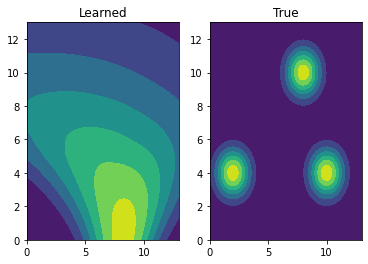

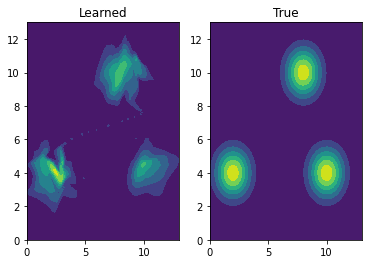

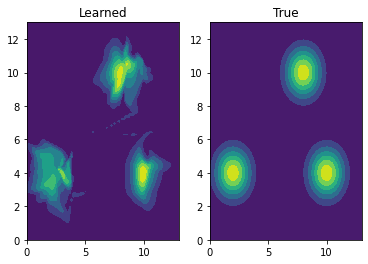

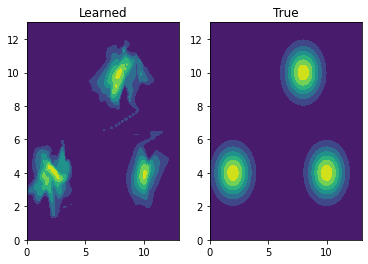

In [234]:
train(flow, x_samples)

#### Results:
- `NaiveLinear` works for multivariate gaussian, but not blobs
- `MaskedAffineAutoregressiveTransform` (one layer only) enables more flexible approximations (not only gaussian) and finds support of target, but no independent blobs yet
- `MaskedAffineAutoregressiveTransform` (5 layers but without permutation inbetween) learns more rapidly but the blobs are still connected
- `RandomPermutation` + `MaskedAffineAutoregressiveTransform` (one layer only) seems to learn more disconnected components but not fast enough
- `ReversePermutation` + `MaskedAffineAutoregressiveTransform` (one layer only) does not work (not even the support is right)
- `RandomPermutation` + `MaskedAffineAutoregressiveTransform` (5 layers) blobs are now rather well approximated but still a little connected and the 3 means have not same weight
- `ReversePermutation` + `MaskedAffineAutoregressiveTransform` (5 layers) blobs are ratther well approximated (and disconnected) and means have more or less the same weights
- `standardizing_transform` before MAF layers - more beautiful approximate (independent blob shapes, equally weighted means)

#### Training Hyperparameters:
- `batch_size` super important (10 too low -  training too long, not too high for more accurate learning - beautiful blobs! - 50 is good!)
- `lr` (same for too low lr, if hidden_features low, need higher lr, if high, need lower lr)

#### Questions:
- `hidden_features` number? defines depth of the flow - expressiveness! 16 here 
- difference between `RandomPermutation` and `ReversePermutation`?
- why permutation before autoregressive layer and not after? 



### Base distributions and transformations

In [44]:
# Define base distribution 
normal_bs = D.MultivariateNormal(torch.zeros(d), torch.eye(d))

mix_bs = D.Categorical(torch.ones(3,))
gmm_means = torch.zeros(3,d)
gmm_stds = torch.eye(d) 
comp_bs = D.multivariate_normal.MultivariateNormal(gmm_means, gmm_stds)
gmm_bs = D.mixture_same_family.MixtureSameFamily(mix_bs, comp_bs)

base_dists = {'normal': normal_bs, 'mixture_normal': gmm_bs}

# Define transformations
parameters = params.DenseAutoregressive(hidden_dims=(32,))
transformations = {'affine': bij.Affine(), 'affineAutoreg': bij.AffineAutoregressive(parameters)}

In [39]:
def plot_2d_pdf_contours(target_dist, x_samples, flow, title=None, n=500, gaussian=False):
    x_true = target_dist.sample((n,))  # Sample from groundtruth
    x_learned = flow.sample((n,)).detach().numpy()  # Sample from learned
    
    plt.scatter(x=x_samples[:,0], y=x_samples[:,1]) # Plot training samples
    sns.kdeplot(x=x_true[:,0], y=x_true[:,1])  # Plot true distribution
    sns.kdeplot(x=x_learned[:,0], y=x_learned[:,1])  # Plot learned distribution
    plt.legend(['Samples', 'True', 'Learned'], loc="upper right")

    if gaussian:
        means_learned = np.mean(x_learned, axis=0)  # Learned mean
        plt.scatter(x=target_dist.mean[0], y=target_dist.mean[1], color='cyan')
        plt.scatter(x=means_learned[0], y=means_learned[1], color='magenta')
    
    plt.title(title)
    plt.show()

### Multivariate Gaussian Target

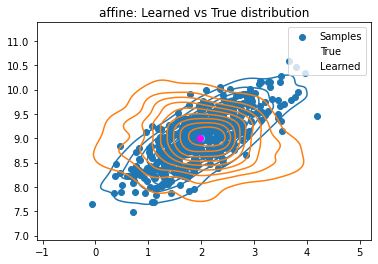

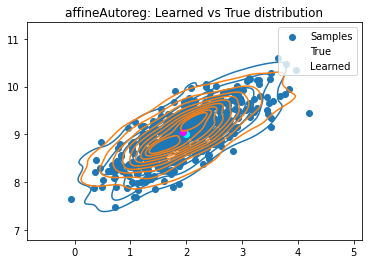

In [41]:
# Generate training data samples
target_dist = target_dists_2D['gaussian'] # We do not usually know this...
x_samples = target_dist.sample((n,))  # ...but all we have are these samples.

for trans in list(transformations.keys()):
    # Construct Flow
    flow = dist.Flow(base_dists['normal'], transformations[trans])
    # Train Flow 
    train(flow, x_samples, num_epochs=500)
    #Evaluate learned pdf
    plot_2d_pdf_contours(target_dist, x_samples, flow, title=trans+': Learned vs True distribution', gaussian=True)

### Blobs/GMM Target

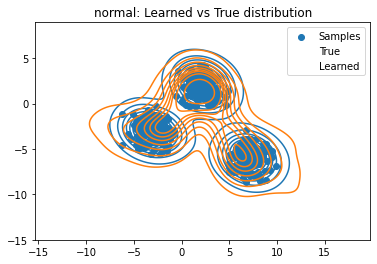

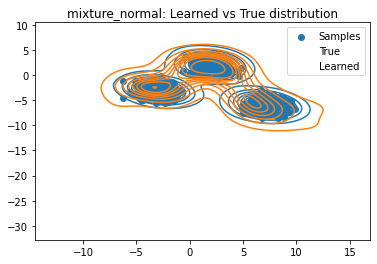

In [42]:
# Generate training data samples
target_dist = target_dists_2D['blobs'] # We do not usually know this...
x_samples = target_dist.sample((n,))  # ...but all we have are these samples.

for base_dist in list(base_dists.keys()):
    # Construct Flow
    flow = dist.Flow(base_dists[base_dist], transformations['affineAutoreg'])
    # Train Flow 
    train(flow, x_samples, num_epochs=2000)
    #Evaluate learned pdf
    plot_2d_pdf_contours(target_dist, x_samples, flow, title=base_dist+': Learned vs True distribution')

TODO: 

- multimodal for affine (not autoreg)
- compose autoreg and perm
- several layers - builds maf 

- other 1D trans? spline?
- coupling layers, splines

- other transformations? combine spline with affine?


Questions:
- autoregressive parameters ? 
- MADE vs MaskedAutoregAffine + perm in nflows 
- How does spline work?
- en 1D comment changer? quand ustilise des nsf et pq?

Influence of:
- permutations between MADEs: without cannot decouple modes - result are connected non equally weighted blobs. They enable to combine different affine transformations on different coordinates which in turn enables to capture the modes.
- number of layers : one not enough to capture the 3 modes of the true target (gets stuck), the more layers, the better the blobs-approximation and the less iterations needed 

TODO: 
look at 1D 